In [3]:
import os
import json
# change the default cache dir so that huggingface won't take the cse space.
os.environ['TRANSFORMERS_CACHE'] = '/export/scratch/zeren/KimNLP/HuggingfaceCache/'

import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm
import torch
import argparse
import periodictable
from transformers import AutoModelForMaskedLM, AutoTokenizer

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

/export/scratch/Zeren/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)

Bad key "text.kerning_factor" on line 4 in
/export/scratch/Zeren/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [74]:
def element_to_symbol_prompting(model, tokenizer, element):
    k = 5
    Prompt = 'In chemistry, chemical element {} is usually referred to as [MASK].'.format(element)
    tokens = tokenizer(Prompt, return_tensors='pt')
    logits = model(**tokens).logits[tokens['input_ids'] == tokenizer.mask_token_id, :].softmax(dim=1)

    topv, topi = logits.topk(k)
    pred_tokens = tokenizer.convert_ids_to_tokens(topi[0])
    return pred_tokens

def symbol_to_element_prompting(model, tokenizer, symbol):
    k = 5
    Prompt = 'In chemistry, the symbol {} usually refers to a chemical element whose name is [MASK].'.format(symbol)
    tokens = tokenizer(Prompt, return_tensors='pt')
    logits = model(**tokens).logits[tokens['input_ids'] == tokenizer.mask_token_id, :].softmax(dim=1)

    topv, topi = logits.topk(k)
    pred_tokens = tokenizer.convert_ids_to_tokens(topi[0])
    return pred_tokens

def eval_propmt_result(label, pred_tokens, topk_list):
    topk_list = sorted(topk_list)
    assert topk_list[-1] <= len(pred_tokens)
    res = {}
    for k in topk_list:
        preds = pred_tokens[:k]
        if label.lower() in preds:
            res[k] = 1.
        else:
            res[k] = 0.
    
    return res

In [141]:
def replace_symbol_by_name(context, symbol2name):
    token_list = context.strip().split(' ')
    res_list = []
    count = 0
    for text in token_list:
        if text in symbol2name:
            res_list.append(symbol2name[text])
            count += 1
        elif text.replace('.', '') in symbol2name:
            res_list.append(symbol2name[text.replace('.', '')])
            count += 1
        elif text.split('-')[0] in symbol2name:
            bond = text.split('-')
            if bond[1] in symbol2name:
                res_list.append(symbol2name[bond[0]] + '-' + symbol2name[bond[1]])
            else:
                res_list.append(symbol2name[bond[0]] + '-' + bond[1])
            count += 1
        else:
            res_list.append(text)
    print('Replaced token number: {}'.format(count))
    return ' '.join(res_list)

In [142]:
symbol2name = {'{}'.format(el.symbol):el.name for el in periodictable.elements}
symbol2name.pop('In')
symbol2name.pop('As')
symbol2name.pop('At')
symbol2name.pop('Be')

sentence = 'Cl is a chemistry element.'
replace_symbol_by_name(sentence, symbol2name)

Replaced token number: 1


'chlorine is a chemistry element.'

In [153]:
data = pd.read_csv('/export/scratch/zeren/KimNLP/Data/kim.tsv', sep='\t')

In [154]:
data.head()

,citation_context,label,split
0,---(1)---Carbon-carbon interactions were model...,not used,train
1,---(1)---interest. Such studies can shed the l...,not used,test
2,---(1)---fabrication of graphene-metal composi...,not used,train
3,---(1)---The phase velocity of the S0 mode wer...,not used,train
4,---(1)---We have performed atomistic modeling ...,used,train


In [155]:
data['citation_context'] = data['citation_context'].apply(replace_symbol_by_name, symbol2name=symbol2name)

Replaced token number: 0
Replaced token number: 1
Replaced token number: 1
Replaced token number: 0
Replaced token number: 2
Replaced token number: 4
Replaced token number: 0
Replaced token number: 0
Replaced token number: 2
Replaced token number: 5
Replaced token number: 3
Replaced token number: 2
Replaced token number: 2
Replaced token number: 3
Replaced token number: 3
Replaced token number: 5
Replaced token number: 2
Replaced token number: 0
Replaced token number: 1
Replaced token number: 1
Replaced token number: 0
Replaced token number: 5
Replaced token number: 2
Replaced token number: 0
Replaced token number: 6
Replaced token number: 0
Replaced token number: 11
Replaced token number: 1
Replaced token number: 2
Replaced token number: 6
Replaced token number: 5
Replaced token number: 1
Replaced token number: 8
Replaced token number: 7
Replaced token number: 0
Replaced token number: 1
Replaced token number: 12
Replaced token number: 7
Replaced token number: 0
Replaced token number: 

In [158]:
data.to_csv('/export/scratch/zeren/KimNLP/Data/kim_symbol_replaced.tsv', sep='\t', header=True, index=False)

In [82]:
# model_name = 'bert-base-uncased'
# model_name = 'allenai/scibert_scivocab_uncased'
model_name = '/export/scratch/zeren/KimNLP/Pre-Trained-SciBERT/checkpoint-213120'
# model_name = '/export/scratch/zeren/KimNLP/Pre-Trained-BERT/checkpoint-213120'
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForMaskedLM.from_pretrained(model_name)

In [57]:
topk_list = [1, 2, 5]
max_count = 5

res = {i: {k: 0. for k in topk_list} for i in range(max_count)}
count = {i: 0. for i in range(max_count)}
for el in periodictable.elements:
    n = len(bert_tokenizer(el.name)['input_ids'])-2
    pred_tokens = element_to_symbol_prompting(bert_model, bert_tokenizer, el.name)
    eval_res = eval_propmt_result(el.symbol, pred_tokens, topk_list)

    for k in topk_list:
        res[0][k] += eval_res[k]
        res[n][k] += eval_res[k]
    count[0] += 1
    count[n] += 1

for i in range(max_count):
    for k in topk_list:
        res[i][k] /= count[i]

print(res)

{0: {1: 0.058823529411764705, 2: 0.24369747899159663, 5: 0.42016806722689076}, 1: {1: 0.0, 2: 0.4473684210526316, 5: 0.868421052631579}, 2: {1: 0.15384615384615385, 2: 0.23076923076923078, 5: 0.28205128205128205}, 3: {1: 0.03225806451612903, 2: 0.0967741935483871, 5: 0.1935483870967742}, 4: {1: 0.0, 2: 0.0, 5: 0.0}}


In [83]:
topk_list = [1, 2, 5]

res = {k: 0. for k in topk_list}
count = 0.
for el in periodictable.elements:
    n = len(bert_tokenizer(el.name)['input_ids'])-2
    if n == 1:
        pred_tokens = symbol_to_element_prompting(bert_model, bert_tokenizer, el.symbol)
        eval_res = eval_propmt_result(el.name, pred_tokens, topk_list)

        for k in topk_list:
            res[k] += eval_res[k]
        count += 1

for k in topk_list:
    res[k] /= count

print(res)

{1: 0.0, 2: 0.05263157894736842, 5: 0.21052631578947367}


In [65]:
num_tokens = []
for el in periodictable.elements:
    print("{} {} {} {}".format(el.symbol, el.name, len(bert_tokenizer(el.symbol)['input_ids']), len(bert_tokenizer(el.name)['input_ids'])))
    num_tokens.append(len(bert_tokenizer(el.name)['input_ids'])-2)
print(np.unique(num_tokens, return_counts=True))

n neutron 3 3
H hydrogen 3 3
He helium 3 3
Li lithium 3 3
Be beryllium 3 5
B boron 3 4
C carbon 3 3
N nitrogen 3 3
O oxygen 3 3
F fluorine 3 5
Ne neon 3 3
Na sodium 3 3
Mg magnesium 3 3
Al aluminum 3 3
Si silicon 3 3
P phosphorus 3 3
S sulfur 3 3
Cl chlorine 3 5
Ar argon 3 4
K potassium 3 3
Ca calcium 3 3
Sc scandium 3 4
Ti titanium 3 3
V vanadium 3 5
Cr chromium 3 5
Mn manganese 3 4
Fe iron 3 3
Co cobalt 3 3
Ni nickel 3 3
Cu copper 3 3
Zn zinc 4 3
Ga gallium 3 4
Ge germanium 3 4
As arsenic 3 3
Se selenium 3 5
Br bromine 3 4
Kr krypton 4 5
Rb rubidium 3 4
Sr strontium 3 5
Y yttrium 3 5
Zr zirconium 4 6
Nb niobium 4 5
Mo molybdenum 3 7
Tc technetium 3 5
Ru ruthenium 3 5
Rh rhodium 4 5
Pd palladium 3 5
Ag silver 3 3
Cd cadmium 3 4
In indium 3 4
Sn tin 4 3
Sb antimony 3 4
Te tellurium 3 5
I iodine 3 4
Xe xenon 4 5
Cs cesium 3 5
Ba barium 3 4
La lanthanum 3 5
Ce cerium 3 4
Pr praseodymium 3 7
Nd neodymium 4 5
Pm promethium 3 5
Sm samarium 3 4
Eu europium 3 5
Gd gadolinium 4 6
Tb terbium 3 

In [9]:
bert_tokenizer.convert_ids_to_tokens(bert_tokenizer('beryllium')['input_ids'])

['[CLS]', 'ber', '##yll', '##ium', '[SEP]']

In [8]:
bert_tokenizer('beryllium')['input_ids']

[101, 10222, 11546, 1346, 102]

In [152]:
element = 'dysprosium'
symbol = 'C'
k = 5
# Prompt = 'The symbol of the chemical element {} is [MASK].'.format(element)
# Prompt = 'In chemistry, chemical element {} is usually referred to as [MASK].'.format(element)
# Prompt = 'In chemistry, chemical element {} usually exists as the [MASK] phase.'.format(element)
# Prompt = 'In chemistry, chemical element {} usually exists as the [MASK] phase.'.format(symbol)
# Prompt = 'In chemistry, {} is usually used as the symbol of element [MASK].'.format(symbol)
Prompt = 'In chemistry, the symbol {} usually refers to a chemical element whose name is [MASK].'.format(symbol)
# Prompt = '{} is the symbol of the chemical element [MASK].'.format(symbol)
# Prompt = 'In chemistry, {} is a [MASK].'.format(symbol)
tokens = bert_tokenizer(Prompt, return_tensors='pt')
logits = bert_model(**tokens).logits[tokens['input_ids'] == bert_tokenizer.mask_token_id, :].softmax(dim=1)

topv, topi = logits.topk(5)
pred_tokens = bert_tokenizer.convert_ids_to_tokens(topi[0])
for p, tk in zip(topv[0].tolist(), pred_tokens):
    print(tk, p)

c 0.15603965520858765
implied 0.03795888274908066
unknown 0.035660021007061005
known 0.02809983678162098
chemical 0.02693762816488743


In [60]:
element = 'dysprosium'
symbol = 'C'
k = 5
# Prompt = 'The symbol of the chemical element {} is [MASK].'.format(element)
# Prompt = 'In chemistry, chemical element {} is usually referred to as [MASK].'.format(element)
# Prompt = 'In chemistry, chemical element {} usually exists as the [MASK] phase.'.format(element)
# Prompt = 'In chemistry, chemical element {} usually exists as the [MASK] phase.'.format(symbol)
Prompt = 'In chemistry, {} is usually used as the symbol to denote element [MASK][MASK].'.format(symbol)
# Prompt = 'In chemistry, the symbol {} usually refers to an chemical element whose name is [MASK].'.format(symbol)
# Prompt = '{} is the symbol of the chemical element [MASK].'.format(symbol)
# Prompt = 'In chemistry, {} is a [MASK].'.format(symbol)
tokens = bert_tokenizer(Prompt, return_tensors='pt')
logits = bert_model(**tokens).logits[tokens['input_ids'] == bert_tokenizer.mask_token_id, :].softmax(dim=1)

topv, topi = logits.topk(5, dim=1)
pred_tokens = bert_tokenizer.convert_ids_to_tokens(topi[0])
print('First Token')
for p, tk in zip(topv[0].tolist(), pred_tokens):
    print(tk, p)

print('Second Token')
pred_tokens = bert_tokenizer.convert_ids_to_tokens(topi[1])
for p, tk in zip(topv[1].tolist(), pred_tokens):
    print(tk, p)

First Token
or 0.39263904094696045
and 0.10191767662763596
b 0.10073577612638474
- 0.055474281311035156
in 0.047000110149383545
Second Token
atom 0.14981579780578613
b 0.06732580810785294
bond 0.06045962870121002
compound 0.03363567590713501
atoms 0.032243289053440094


In [23]:
tokens

{'input_ids': tensor([[ 102,  111, 5888,  131,  111, 2828, 2690, 5326,  165,  104,  205,  103]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [35]:
topv, topi = res.logits[tokens['input_ids'] == bert_tokenizer.mask_token_id, :].topk(5)
print(topi[0])


tensor([  501, 29580, 12919,   817,   158])


['used', 'underlined', 'omitted', 'shown', '1']

In [103]:
def merge_annotations(x, y):
    if type(y) == str:
        return y.strip().lower()
    return x.strip().lower()

def dict_to_gpu(input_dict):
    output_dict = {key: value.cuda() for key, value in input_dict.items()}
    return output_dict

In [104]:
def load_kim_dataset(data_filename = '/export/scratch/zeren/KimNLP/RawData/dec_12_annotations.tsv'):
    data = pd.read_csv(data_filename, sep='\t')

    data['annotation'] = data.apply(lambda x: merge_annotations(x['previous annotation'], x['new annotation']), axis=1)
    columns = ['cited title', 'cited abstract', 'citing title', 'citing abstract', 'citation context', 'annotation']
    data = data[columns]
    data = data.rename(columns={
        'cited title': 'cited_title', 
        'cited abstract': 'cited_abstract', 
        'citing title': 'citing_title', 
        'citing abstract': 'citing_abstract', 
        'citation context': 'citation_context', 
        'annotation': 'label'
    }).reset_index().drop(columns='index')
    data = data.fillna('')
    data.head()
    return data

def load_acl_scicite_dataset(data_dir, data_name):
    train_data_filename = os.path.join(
        data_dir, '{}_train_with_abstracts.jsonl'.format(data_name)
    )
    test_data_filename = os.path.join(
        data_dir, '{}_test_with_abstracts.jsonl'.format(data_name)
    )

    with open(train_data_filename, 'r') as train_f:
        train_list = train_f.readlines()
    
    with open(test_data_filename, 'r') as test_f:
        test_list = test_f.readlines()
    
    train_data = []
    test_data = []
    for json_str in train_list:
        json_dict = json.loads(json_str)
        train_data.append(json_dict)
    
    for json_str in test_list:
        json_dict = json.loads(json_str)
        test_data.append(json_dict)

    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)

    train_df = train_df.fillna('')
    test_df = test_df.fillna('')

    return train_df, test_df

In [105]:
data = load_kim_dataset()
# data, _ = load_acl_scicite_dataset('/export/scratch/zeren/KimNLP/RawData/datasets', 'scicite')

In [106]:
data.head()

,cited_title,cited_abstract,citing_title,citing_abstract,citation_context,label
0,New empirical approach for the structure and e...,Empirical interatomic potentials permit the ca...,Simulation of carbon nanotube welding through ...,Single-walled carbon nanotubes show promise as...,---(1)---Carbon-carbon interactions were model...,not used
1,Computer simulation of local order in condense...,A model potential-energy function comprising b...,Nickel nanoparticles inside carbon nanostructu...,"Ni nanoparticle on a graphene substrate, insid...",---(1)---interest. Such studies can shed the l...,not used
2,Analytic bond-order potential for the gallium ...,"An analytic, bond-order potential BOP is propo...",Nickel nanoparticles inside carbon nanostructu...,"Ni nanoparticle on a graphene substrate, insid...",---(1)---fabrication of graphene-metal composi...,not used
3,Interaction potential for silicon carbide: A m...,An effective interatomic interaction potential...,Amorphous SiC/c-ZnO-based Lamb mode sensor for...,,---(1)---The phase velocity of the S0 mode wer...,not used
4,"Empirical interatomic potential for carbon, wi...",An empirical interatomic potential is introduc...,Thermal Conductivity and Mechanical Properties...,"Nitrogenated holey graphene (NHG), a two-dimen...",---(1)---We have performed atomistic modeling ...,used


In [124]:
# symbol2name.pop('in')
# symbol2name.pop('as')
# symbol2name.pop('at')
# symbol2name.pop('be')

'beryllium'

In [143]:
data['replaced_context'] = data['citation_context'].apply(replace_symbol_by_name, symbol2name=symbol2name)

Replaced token number: 0
Replaced token number: 1
Replaced token number: 1
Replaced token number: 0
Replaced token number: 2
Replaced token number: 4
Replaced token number: 0
Replaced token number: 0
Replaced token number: 2
Replaced token number: 5
Replaced token number: 3
Replaced token number: 2
Replaced token number: 2
Replaced token number: 3
Replaced token number: 3
Replaced token number: 5
Replaced token number: 2
Replaced token number: 0
Replaced token number: 1
Replaced token number: 1
Replaced token number: 0
Replaced token number: 5
Replaced token number: 2
Replaced token number: 0
Replaced token number: 6
Replaced token number: 0
Replaced token number: 11
Replaced token number: 1
Replaced token number: 2
Replaced token number: 6
Replaced token number: 5
Replaced token number: 1
Replaced token number: 8
Replaced token number: 7
Replaced token number: 0
Replaced token number: 1
Replaced token number: 12
Replaced token number: 7
Replaced token number: 0
Replaced token number: 

In [111]:
data.head()

,cited_title,cited_abstract,citing_title,citing_abstract,citation_context,label,replaced_context
0,New empirical approach for the structure and e...,Empirical interatomic potentials permit the ca...,Simulation of carbon nanotube welding through ...,Single-walled carbon nanotubes show promise as...,---(1)---Carbon-carbon interactions were model...,not used,---(1)---carbon-carbon interactions were model...
1,Computer simulation of local order in condense...,A model potential-energy function comprising b...,Nickel nanoparticles inside carbon nanostructu...,"Ni nanoparticle on a graphene substrate, insid...",---(1)---interest. Such studies can shed the l...,not used,---(1)---interest. such studies can shed the l...
2,Analytic bond-order potential for the gallium ...,"An analytic, bond-order potential BOP is propo...",Nickel nanoparticles inside carbon nanostructu...,"Ni nanoparticle on a graphene substrate, insid...",---(1)---fabrication of graphene-metal composi...,not used,---(1)---fabrication of graphene-metal composi...
3,Interaction potential for silicon carbide: A m...,An effective interatomic interaction potential...,Amorphous SiC/c-ZnO-based Lamb mode sensor for...,,---(1)---The phase velocity of the S0 mode wer...,not used,---(1)---the phase velocity of the s0 mode wer...
4,"Empirical interatomic potential for carbon, wi...",An empirical interatomic potential is introduc...,Thermal Conductivity and Mechanical Properties...,"Nitrogenated holey graphene (NHG), a two-dimen...",---(1)---We have performed atomistic modeling ...,used,---(1)---we have performed atomistic modeling ...


In [150]:
data['citation_context'].values[5]

'---(1)---We have performed atomistic modeling of NHG via classical molecular dynamics simulations (MD) where the Tersoff bond-order potential was employed to describe interatomic forces BIBREF9 , <CITED HERE> . Although the Tersoff potential has not been parameterized to model NHG specifically, it has already been parameterized for graphene BIBREF11 , hexagonal boron nitride (hBN) BIBREF12 , and graphene–hBN structures BIBREF13 . Therefore, in the present work we employed potential parameters from Lindsay and Broido BIBREF11 , BIBREF12 for C-C interaction and obtained the parameters for C-N via the usual mixing rules for the Tersoff potential BIBREF10 .---(2)---We have performed atomistic modeling of NHG via classical molecular dynamics simulations (MD) where the Tersoff bond-order potential was employed to describe interatomic forces BIBREF9 , BIBREF10 . Although the Tersoff potential has not been parameterized to model NHG specifically, it has already been parameterized for graphene

In [151]:
data['replaced_context'].values[5]

'---(1)---We have performed atomistic modeling of NHG via classical molecular dynamics simulations (MD) where the Tersoff bond-order potential was employed to describe interatomic forces BIBREF9 , <CITED HERE> . Although the Tersoff potential has not been parameterized to model NHG specifically, it has already been parameterized for graphene BIBREF11 , hexagonal boron nitride (hBN) BIBREF12 , and graphene–hBN structures BIBREF13 . Therefore, in the present work we employed potential parameters from Lindsay and Broido BIBREF11 , BIBREF12 for carbon-carbon interaction and obtained the parameters for carbon-nitrogen via the usual mixing rules for the Tersoff potential BIBREF10 .---(2)---We have performed atomistic modeling of NHG via classical molecular dynamics simulations (MD) where the Tersoff bond-order potential was employed to describe interatomic forces BIBREF9 , BIBREF10 . Although the Tersoff potential has not been parameterized to model NHG specifically, it has already been para

In [22]:
bert_model = bert_model.cuda()
bert_model.eval()

cited_title_embs = []
cited_abstract_embs = []
citing_title_embs = []
citing_abstract_embs = []

with torch.no_grad():
    for idx in tqdm(range(data.shape[0])):
        cited_title_tokens = dict_to_gpu(bert_tokenizer(data['cited_title'].values[idx], return_tensors='pt', max_length=512, truncation=True))
        citing_title_tokens = dict_to_gpu(bert_tokenizer(data['citing_title'].values[idx], return_tensors='pt', max_length=512, truncation=True))
        cited_abstract_tokens = dict_to_gpu(bert_tokenizer(data['cited_abstract'].values[idx], return_tensors='pt', max_length=512, truncation=True))
        citing_abstract_tokens = dict_to_gpu(bert_tokenizer(data['citing_abstract'].values[idx], return_tensors='pt', max_length=512, truncation=True))

        cited_title_embs.append(bert_model(**cited_title_tokens))
        citing_title_embs.append(bert_model(**citing_title_tokens))
        cited_abstract_embs.append(bert_model(**cited_abstract_tokens))
        citing_abstract_embs.append(bert_model(**citing_abstract_tokens))

  0%|          | 0/8052 [00:00<?, ?it/s]

In [23]:
cited_title_embs = torch.stack([tensor.last_hidden_state[0].mean(dim=0) for tensor in cited_title_embs]).cpu()
cited_abstract_embs = torch.stack([tensor.last_hidden_state[0].mean(dim=0) for tensor in cited_abstract_embs]).cpu()
citing_title_embs = torch.stack([tensor.last_hidden_state[0].mean(dim=0) for tensor in citing_title_embs]).cpu()
citing_abstract_embs = torch.stack([tensor.last_hidden_state[0].mean(dim=0) for tensor in citing_abstract_embs]).cpu()

In [24]:
title_diff = cited_title_embs - citing_title_embs
abstract_diff = cited_abstract_embs - citing_abstract_embs

In [25]:
title_diff_norm = (cited_title_embs - citing_title_embs).norm(dim=1).numpy()
abstract_diff_norm = (cited_abstract_embs - citing_abstract_embs).norm(dim=1).numpy()

In [26]:
categories, count = np.unique(data['label'].values, return_counts=True)
cate2id = {c:i for i, c in enumerate(categories)}
cate_colors = np.array([cate2id[c] for c in data['label'].values])
title_diff_norm_dict = {c: title_diff_norm[data['label'].values == c] for c in categories}
abstract_diff_norm_dict = {c: abstract_diff_norm[data['label'].values == c] for c in categories}

In [27]:
tsne_title_diff = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500, random_state=42)
tsne_title_diff_results = tsne_title_diff.fit_transform(title_diff)

tsne_abstract_diff = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500, random_state=42)
tsne_abstract_diff_results = tsne_abstract_diff.fit_transform(abstract_diff)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8052 samples in 0.251s...
[t-SNE] Computed neighbors for 8052 samples in 45.574s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8052
[t-SNE] Computed conditional probabilities for sample 2000 / 8052
[t-SNE] Computed conditional probabilities for sample 3000 / 8052
[t-SNE] Computed conditional probabilities for sample 4000 / 8052
[t-SNE] Computed conditional probabilities for sample 5000 / 8052
[t-SNE] Computed conditional probabilities for sample 6000 / 8052
[t-SNE] Computed conditional probabilities for sample 7000 / 8052
[t-SNE] Computed conditional probabilities for sample 8000 / 8052
[t-SNE] Computed conditional probabilities for sample 8052 / 8052
[t-SNE] Mean sigma: 3.335773
[t-SNE] KL divergence after 250 iterations with early exaggeration: 117.104889
[t-SNE] KL divergence after 500 iterations: 3.149836
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8052 samples in 0.258s...
[t-SNE] Computed 

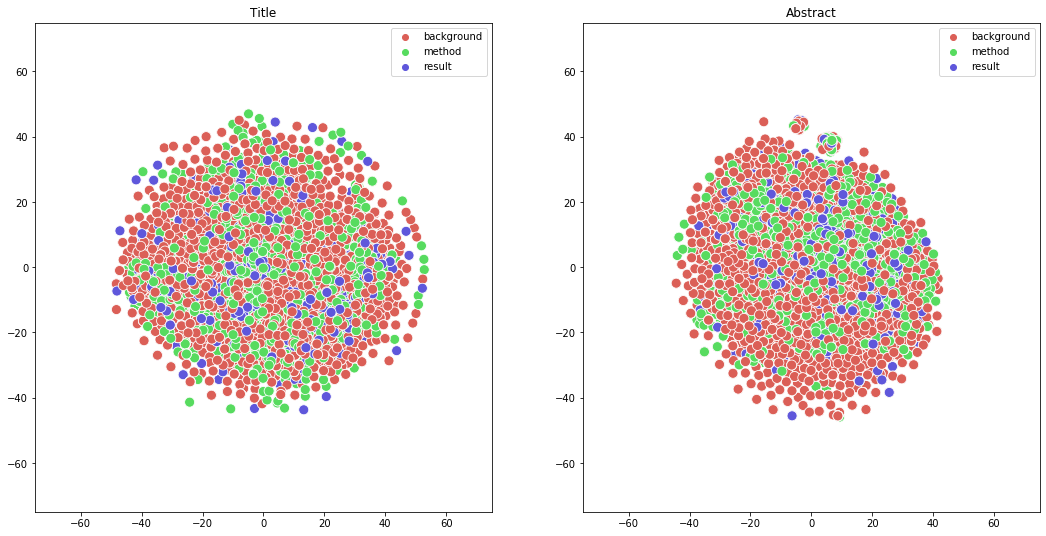

In [31]:
plt.figure(figsize=(18, 9))

plt.subplot(1, 2, 1)
plt.title('Title')
sns.scatterplot(
    x=tsne_title_diff_results[:, 0], y=tsne_title_diff_results[:, 1],
    hue=data['label'].values,
    palette=sns.color_palette("hls", len(np.unique(data['label'].values))),
    legend="full",
    alpha=1.,
    s=100
)
plt.xlim([-75, 75])
plt.ylim([-75, 75])

plt.subplot(1, 2, 2)
plt.title('Abstract')
sns.scatterplot(
    x=tsne_abstract_diff_results[:, 0], y=tsne_abstract_diff_results[:, 1],
    hue=data['label'].values,
    palette=sns.color_palette("hls", len(np.unique(data['label'].values))),
    legend="full",
    alpha=1.,
    s=100
)
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.legend()
plt.show()

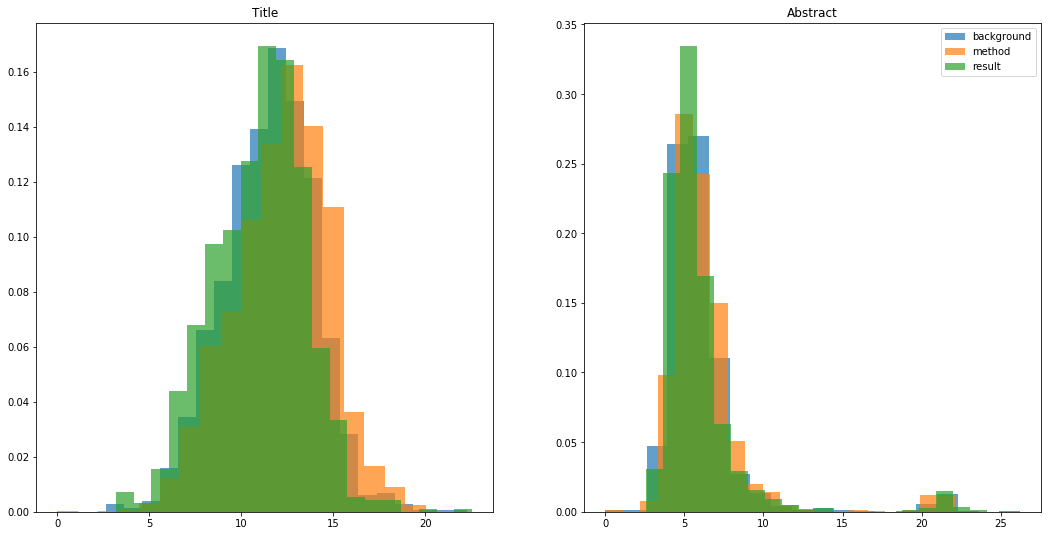

In [32]:
plt.figure(figsize=(18, 9))

plt.subplot(1, 2, 1)
plt.title('Title')
for key, value in title_diff_norm_dict.items():
    if key != 'not sure':
        plt.hist(value, bins=20, alpha=0.7, label=key, density=True)

plt.subplot(1, 2, 2)
plt.title('Abstract')
for key, value in abstract_diff_norm_dict.items():
    if key != 'not sure':
        plt.hist(value, bins=20, alpha=0.7, label=key, density=True)

plt.legend()
plt.show()